In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchvision.models import inception_v3, Inception_V3_Weights

In [ ]:
device=torch.device('mps' if torch.mps.is_available()else 'cpu')
print(device)

mps


In [4]:
#Dataset processing
train_dataset=torchvision.datasets.CIFAR10(root='./data',train=True, download=False,transform=transforms.ToTensor())
size_train_data=len(train_dataset)
loader=DataLoader(train_dataset,batch_size=size_train_data,shuffle=False)
def mean_std(loader):
    images,_=next(iter(loader))
    mean=images.mean(dim=(0,2,3))
    std=images.std(dim=(0,2,3))
    return mean, std

In [5]:
mean,std=mean_std(loader)

train_transforms=transforms.Compose([transforms.Resize(330),transforms.RandomCrop(299),transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean,std)])
test_transforms=transforms.Compose([transforms.Resize(299),transforms.ToTensor(),transforms.Normalize(mean,std)])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transforms)
val_ratio = 0.1
train_length = int((1 - val_ratio) * len(full_train_dataset))
val_length = len(full_train_dataset) - train_length
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_length, val_length])
val_dataset.dataset.transform = test_transforms
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transforms)


In [6]:
train_loader=DataLoader(train_dataset,batch_size=8,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=8,shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

model=inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1,aux_logits=True)
model.fc=nn.Linear(model.fc.in_features,10)
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
patience=3
best_accuracy=0
counter=0

Epoch [1/15], Loss: 1.8112
Validation Accuracy: 74.98%


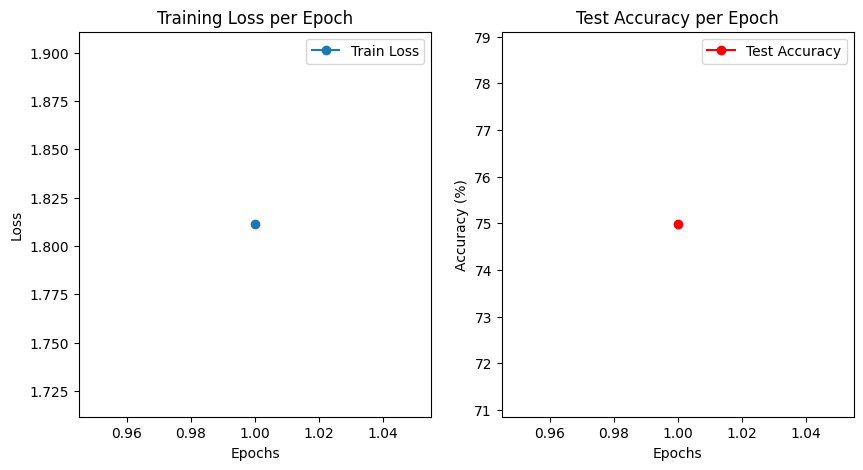

Epoch [2/15], Loss: 1.1370
Validation Accuracy: 80.16%
Epoch [3/15], Loss: 0.8663
Validation Accuracy: 84.18%
Epoch [4/15], Loss: 0.6958
Validation Accuracy: 86.42%
Epoch [5/15], Loss: 0.5762
Validation Accuracy: 86.90%


In [ ]:
num_epochs=15

train_losses = []
test_accuracies = []
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        if model.training:
            loss_main = criterion(outputs.logits, labels)
            loss_aux = criterion(outputs.aux_logits, labels)
            loss = loss_main + 0.4 * loss_aux
        else:
            loss=criterion(outputs.logits,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    val_accuracy = 100 * correct / total
    test_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

    ax1.clear()
    ax1.plot(range(1, epoch + 2), train_losses, marker='o', linestyle='-', label='Train Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss per Epoch')
    ax1.legend()

    ax2.clear()
    ax2.plot(range(1, epoch + 2), test_accuracies, marker='o', linestyle='-', color='red', label='Test Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Test Accuracy per Epoch')
    ax2.legend()

    plt.pause(0.1)

plt.ioff()
plt.show()

